In [208]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import spconv.pytorch as spconv
from sklearn.metrics import f1_score

In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [210]:
with h5py.File('data/train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']

    val_data = []

    data = []
    for i, event in enumerate(label_events):
        if i < 500:
            val_data.append(f['data'][i].reshape(-1,4))
            continue
        
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)
    
#     n_signal_events = 0
    
#     n_michel_voxels = np.zeros(len(label_events))

#     # Iterate and print each event (which is a variable-length array)
#     for i, event in enumerate(label_events):
#         print(f"Event {i}: {event} (length = {len(event)})")
#         n_signal_events += np.any(event == 2)
#         n_michel_voxels[i] = np.sum(event == 2)

# # Corrected the misplaced parenthesis in the print statement
# print("Fraction of events with Michel electrons:", (n_signal_events / len(label_events)) * 100, "%")

In [211]:
# Open the labels file
with h5py.File('data/train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []
    val_labels = []

    for i, event in enumerate(label_events):
        if i < 500:
            val_labels.append(event)
            continue
    
        labels.append(event)

In [212]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
val_truth = [(event_labels == 2).astype(np.int32) for event_labels in val_labels]
# val_truth = torch.tensor([x for x_event in val_truth for x in x_event]).to(device)

In [213]:
# Input: sparse tensor with coordinates and features
# coordinates: Nx4 tensor (batch_idx, x, y, z)
# features: Nx1 tensor (voxel values)
# Iterate over the events and create sparse tensors
# Example input data

features = []
coords = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, input_event in enumerate(data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    features.append(input_feats)
    coords.append(input_coords)

val_features = []
val_coords = []
for i, input_event in enumerate(val_data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    val_features.append(input_feats)
    val_coords.append(input_coords)

In [214]:
input_feats = torch.cat(features, dim=0)
input_coords = torch.cat(coords, dim=0)

val_input_feats = torch.cat(val_features, dim=0)
val_input_coords = torch.cat(val_coords, dim=0)

input_feats_scaled = input_feats / 20
val_input_feats_scaled = val_input_feats / 20

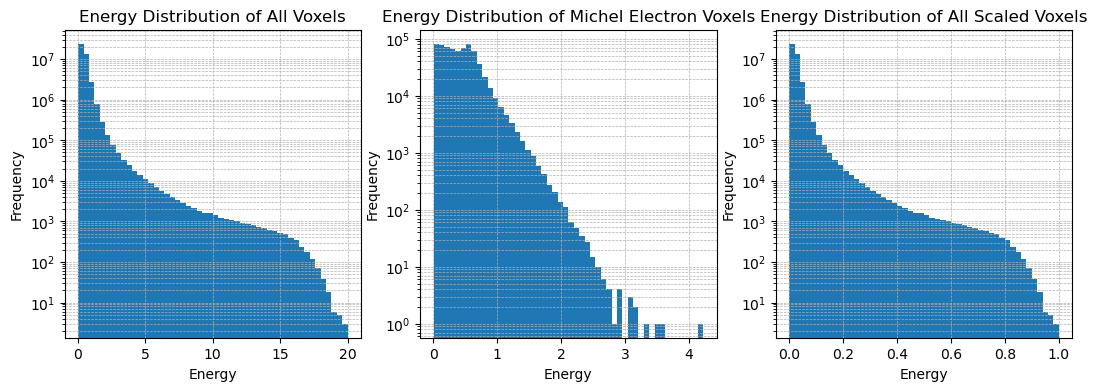

In [215]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
axs[0].hist(input_feats.numpy(), bins=50)
axs[0].set(title='Energy Distribution of All Voxels', xlabel='Energy', ylabel='Frequency')

axs[1].hist(np.concatenate([input_event[:, 3][label_event == 2] for input_event, label_event in zip(data, labels)]), bins=50)
axs[1].set(title='Energy Distribution of Michel Electron Voxels', xlabel='Energy', ylabel='Frequency')

axs[2].hist(input_feats_scaled.numpy(), bins=50)
axs[2].set(title='Energy Distribution of All Scaled Voxels', xlabel='Energy', ylabel='Frequency')

for ax in axs:
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

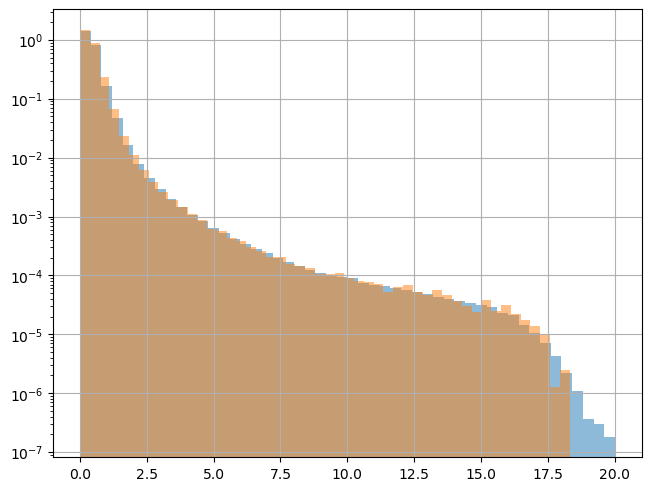

In [216]:
fig, ax = plt.subplots(layout="constrained")
ax.hist(input_feats.numpy(), bins=50, alpha=0.5, density=True, label='Training Data')
ax.hist(val_input_feats.numpy(), bins=50, alpha=0.5, density=True, label='Validation Data')
ax.set(yscale="log")
ax.grid()

In [217]:
# Should be roughly the same
np.mean(np.concatenate(truth)), np.mean(np.concatenate(val_truth))

(np.float64(0.01618287655124552), np.float64(0.016538400879536827))

(array([7.530e+02, 1.732e+03, 2.235e+03, 1.985e+03, 1.215e+03, 5.520e+02,
        3.850e+02, 3.020e+02, 1.580e+02, 8.100e+01, 4.400e+01, 2.300e+01,
        1.400e+01, 1.000e+01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  7.  ,  25.84,  44.68,  63.52,  82.36, 101.2 , 120.04, 138.88,
        157.72, 176.56, 195.4 , 214.24, 233.08, 251.92, 270.76, 289.6 ,
        308.44, 327.28, 346.12, 364.96, 383.8 , 402.64, 421.48, 440.32,
        459.16, 478.  , 496.84, 515.68, 534.52, 553.36, 572.2 , 591.04,
        609.88, 628.72, 647.56, 666.4 , 685.24, 704.08, 722.92, 741.76,
        760.6 , 

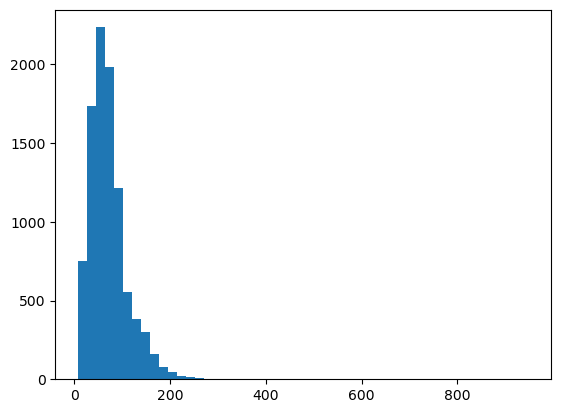

In [218]:
# Should be roughly the same
plt.hist([np.sum(t) for t in truth], bins=50)

In [219]:
class AutoEncoder(nn.Module):
    def __init__(self, shape, kernel_size, stride):
        super().__init__()
        self.encoder = spconv.SparseSequential(
            spconv.SparseConv3d(1, 1, kernel_size=kernel_size, stride=stride, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
            spconv.SparseConv3d(1, 1, kernel_size=kernel_size, stride=stride, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            # spconv.SparseMaxPool3d(kernel_size=kernel_size, stride=stride, padding=0, algo=spconv.ConvAlgo.Native, indice_key="mp0"),
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
            spconv.SparseConv3d(1, 1, kernel_size=kernel_size, stride=stride, algo=spconv.ConvAlgo.Native, indice_key="cp2"),
            spconv.SparseConv3d(1, 1, kernel_size=kernel_size, stride=stride, algo=spconv.ConvAlgo.Native, indice_key="cp3"),
            # spconv.SparseMaxPool3d(kernel_size=kernel_size, stride=stride, padding=0, algo=spconv.ConvAlgo.Native, indice_key="mp1"),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
        )

        self.decoder = spconv.SparseSequential(
            # spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="mp1"), 
            spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="cp3"), 
            spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="cp2"), 
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            # nn.ReLU(),
            # spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="mp0"), 
            spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            spconv.SparseInverseConv3d(1, 1, kernel_size=kernel_size, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
        )
        self.shape = shape

    def forward(self, features, coors, batch_size):
        coors = coors.int()
        x = spconv.SparseConvTensor(features, coors, self.shape, batch_size)
        # print("Input shape:", x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [220]:
def compute_validation_output(model, val_truth, val_input_feats, val_input_coords, val_batch_size=10):
    """Compute the model output for the validation data"""

    val_n_voxels = [len(e) for e in val_truth]
    val_n_voxels_cumsum = np.cumsum(val_n_voxels)

    preds = []

    for i, batch in enumerate(range(0, len(val_truth), val_batch_size)):
        voxel_i_lower = 0 if batch == 0 else val_n_voxels_cumsum[batch - 1]
        voxel_i_upper = val_n_voxels_cumsum[batch + val_batch_size-1] if (batch + val_batch_size-1) < len(val_truth) else val_n_voxels_cumsum[-1]
        batch_input_feats = val_input_feats[voxel_i_lower:voxel_i_upper]
        batch_input_coords = val_input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
        
        # print(batch_input_coords[:, 0].min().item(), batch_input_coords[:, 0].max().item())
        
        # From batch_input_coords, subtract the batch number to make indices start from 0
        batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch
        # Defensive: skip if batch_input_coords is empty
        if batch_input_coords.shape[0] == 0:
            print("Empty batch. Skip")
            continue

        # Defensive: check max batch index only if not empty
        # if batch_input_coords.shape[0] > 0:
            # assert batch_input_coords[:, 0].max().item() == val_batch_size - 1, batch_input_coords[:, 0].max().item()
            # assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()
        
        model.eval()
        with torch.no_grad():
            output_sparse = model(batch_input_feats, batch_input_coords, batch_size=val_batch_size if batch + val_batch_size < len(val_truth) else len(val_truth) - batch)

            preds.append(output_sparse.features)

    preds = torch.cat(preds, dim=0)
    
    return preds

In [190]:
model = AutoEncoder([768, 768, 768], kernel_size=3, stride=2).to(device)

# train model using the truth labels
n_voxels = [len(t) for t in truth]
n_voxels_cumsum = np.cumsum(n_voxels)
val_truth_flat = np.concatenate(val_truth)
truth_flat = np.concatenate(truth)

n_epochs = 6
loss_per_epoch = np.zeros(n_epochs)
val_loss_per_epoch = np.zeros(n_epochs)

loss_fn = nn.BCEWithLogitsLoss()

batch_size = 10  # Define batch size
batch_indices = range(0, len(data), batch_size)

for epoch in range(n_epochs):  # Example training loop
    # loss_per_batch = [None] * len(batch_indices)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i, batch in enumerate(tqdm(batch_indices)):  # Batch size of 5
        voxel_i_lower = 0 if batch == 0 else n_voxels_cumsum[batch - 1]
        voxel_i_upper = n_voxels_cumsum[batch + batch_size-1] if (batch + batch_size-1) < len(data) else n_voxels_cumsum[-1]

        batch_input_feats = input_feats_scaled[voxel_i_lower:voxel_i_upper]
        batch_input_coords = input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
        # From batch_input_coords, subtract the batch number to make indices start from 0
        batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch

        # Defensive: skip if batch_input_coords is empty
        if batch_input_coords.shape[0] == 0:
            print("Empty batch. Skip")
            continue

        batch_truth = torch.tensor(np.concatenate(truth[batch:batch+batch_size]), dtype=torch.float32).unsqueeze(1)
        
        model.train()
        optimizer.zero_grad()
        output_sparse = model(batch_input_feats.to(device), batch_input_coords.to(device), batch_size=batch_size if batch + batch_size < len(data) else len(data) - batch)
        output_sparse.features[torch.isnan(output_sparse.features)] = 0  # Replace nan values with 0
        loss = loss_fn(output_sparse.features, batch_truth.to(device))

        loss.backward()
        optimizer.step()
        # loss_per_batch[i] = loss.detach().clone()
    
    # Free up the cache
    torch.cuda.empty_cache()
    
    # Save the loss
    # loss_per_epoch[epoch] = torch.nanmean(torch.cat(loss_per_batch)).detach().item()

    val_model_output = compute_validation_output(model, val_truth, val_input_feats.to(device), val_input_coords.to(device), val_batch_size=batch_size)
    
    train_model_output = compute_validation_output(model, truth, input_feats.to(device), input_coords.to(device), val_batch_size=batch_size)
    
    with torch.no_grad():
        # Replace nan values with 0
        val_model_output[torch.isnan(val_model_output)] = 0
        train_model_output[torch.isnan(train_model_output)] = 0
        # Compute the loss
        val_loss_per_epoch[epoch] = loss_fn(val_model_output, torch.tensor(val_truth_flat, dtype=torch.float).unsqueeze(1).to(device)).detach().item()
        loss_per_epoch[epoch] = loss_fn(train_model_output, torch.tensor(truth_flat, dtype=torch.float).unsqueeze(1).to(device)).detach().item()
    
    # Save a copy of the model every epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

  4%|▍         | 411/9500 [00:12<04:41, 32.32it/s]


KeyboardInterrupt: 

In [ ]:
def compute_output(model, features, coords, batch_size):
    """Compute the model output for the validation data"""

    preds = []

    for i, batch in enumerate(tqdm(batch_indices)):
        batch_input_feats = features[batch:batch + batch_size]
        batch_input_coords = [c.detach().clone() for c in coords[batch:batch + batch_size]]
        
        for j in range(len(batch_input_coords)):
            batch_input_coords[j][:, 0] = j
        
        batch_input_feats = torch.cat(batch_input_feats, dim=0) / 20.
        batch_input_coords = torch.cat(batch_input_coords, dim=0)

        model.eval()
        with torch.no_grad():
            output_sparse = model(batch_input_feats.to(device), batch_input_coords.to(device), batch_size=batch_size if batch + batch_size < len(data) else len(data) - batch)
    
            preds.append(output_sparse.features)

    preds = torch.cat(preds, dim=0)
    
    return preds

model = AutoEncoder([768, 768, 768], kernel_size=3, stride=2).to(device)

n_epochs = 3
loss_per_epoch = np.zeros(n_epochs)
val_loss_per_epoch = np.zeros(n_epochs)

loss_fn = nn.BCEWithLogitsLoss()

batch_size = 20  # Define batch size
batch_indices = range(0, len(data), batch_size)

for epoch in range(n_epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i, batch in enumerate(tqdm(batch_indices)):
        batch_input_feats = features[batch:batch + batch_size]
        batch_input_coords = [c.detach().clone() for c in coords[batch:batch + batch_size]]
        
        for j in range(len(batch_input_coords)):
            batch_input_coords[j][:, 0] = j
        
        batch_input_feats = torch.cat(batch_input_feats, dim=0) / 20.
        batch_input_coords = torch.cat(batch_input_coords, dim=0)
        # print(batch_input_coords)

        batch_truth = torch.tensor(np.concatenate(truth[batch:batch+batch_size]), dtype=torch.float32).unsqueeze(1)
        
        model.train()
        optimizer.zero_grad()
        output_sparse = model(batch_input_feats.to(device), batch_input_coords.to(device), batch_size=batch_size if batch + batch_size < len(data) else len(data) - batch)
        output_sparse.features[torch.isnan(output_sparse.features)] = 0  # Replace nan values with 0
        loss = loss_fn(output_sparse.features, batch_truth.to(device))

        loss.backward()
        optimizer.step()
        break

    # Free up the cache
    torch.cuda.empty_cache()
    
    # Save the loss
    # loss_per_epoch[epoch] = torch.nanmean(torch.cat(loss_per_batch)).detach().item()

    val_model_output = compute_output(model, val_features, val_coords, batch_size=batch_size)
    
    train_model_output = compute_output(model, features, coords, batch_size=batch_size)
    
    with torch.no_grad():
        # Replace nan values with 0
        val_model_output[torch.isnan(val_model_output)] = 0
        train_model_output[torch.isnan(train_model_output)] = 0
        # Compute the loss
        val_loss_per_epoch[epoch] = loss_fn(val_model_output, torch.tensor(val_truth_flat, dtype=torch.float).unsqueeze(1).to(device)).detach().item()
        loss_per_epoch[epoch] = loss_fn(train_model_output, torch.tensor(truth_flat, dtype=torch.float).unsqueeze(1).to(device)).detach().item()
    
    # Save a copy of the model every epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

  1%|          | 4/475 [00:00<00:12, 39.05it/s]

a
a
a
a
a
a
a
a
a


  3%|▎         | 14/475 [00:00<00:11, 40.92it/s]

a
a
a
a
a
a
a
a


  5%|▌         | 25/475 [00:00<00:11, 39.76it/s]

a
a
a
a
a
a
a
a


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [239]:
val_coords

[tensor([[  0, 204, 435, 290],
         [  0, 180, 431, 290],
         [  0, 202, 421, 290],
         ...,
         [  0, 378, 290, 505],
         [  0, 375, 291, 505],
         [  0, 357, 261, 484]], dtype=torch.int32),
 tensor([[  1,  51, 425, 654],
         [  1,  51, 424, 654],
         [  1,  41, 424, 630],
         ...,
         [  1, 409, 321, 141],
         [  1, 405, 322, 141],
         [  1, 406, 322, 141]], dtype=torch.int32),
 tensor([[  2, 287, 440,  11],
         [  2, 286, 434,   7],
         [  2, 286, 433,   7],
         ...,
         [  2, 627, 241, 165],
         [  2, 626, 242, 165],
         [  2, 627, 240, 165]], dtype=torch.int32),
 tensor([[  3, 153, 390, 392],
         [  3, 153, 389, 392],
         [  3, 501, 498, 123],
         ...,
         [  3, 443, 485, 224],
         [  3, 442, 485, 224],
         [  3, 442, 485, 223]], dtype=torch.int32),
 tensor([[  4, 273,   2,   0],
         [  4, 164, 254, 230],
         [  4, 492, 203,   7],
         ...,
         

In [230]:
v[:, 0] = 0

In [231]:
v

tensor([[  0, 533, 722, 764],
        [  0, 346,   9, 140],
        [  0, 257,  74, 139],
        ...,
        [  0, 529, 712, 758],
        [  0, 529, 711, 757],
        [  0, 529, 712, 757]], dtype=torch.int32)

[Text(0.5, 0, 'Neural network output'), Text(0, 0.5, 'Number of voxels')]

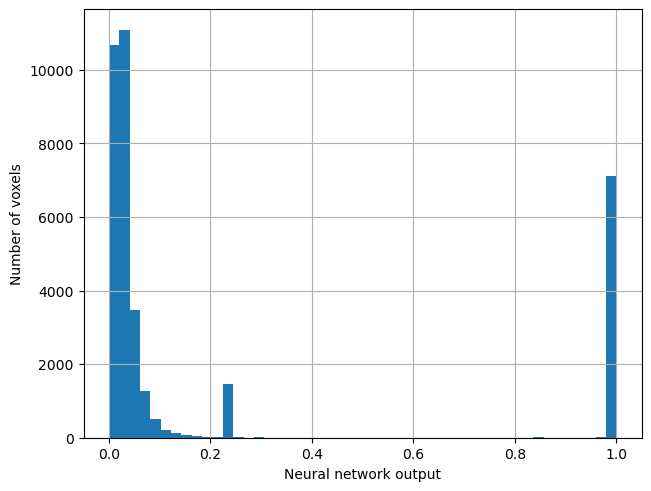

In [ ]:
fig, ax = plt.subplots(layout="constrained")

ax.hist(sigmoid(preds_100[np.concatenate(val_truth) == 1]).cpu().numpy(), bins=np.linspace(0, 1, 50))
ax.grid()
ax.set(xlabel="Neural network output", ylabel="Number of voxels")

In [200]:
batch_input_coords

tensor([[  5, 590, 100,  85],
        [  5, 358, 485, 765],
        [  5, 354, 496, 747],
        ...,
        [  9, 608,  27, 646],
        [  9, 608,  26, 646],
        [  9, 609,  31, 645]], dtype=torch.int32)

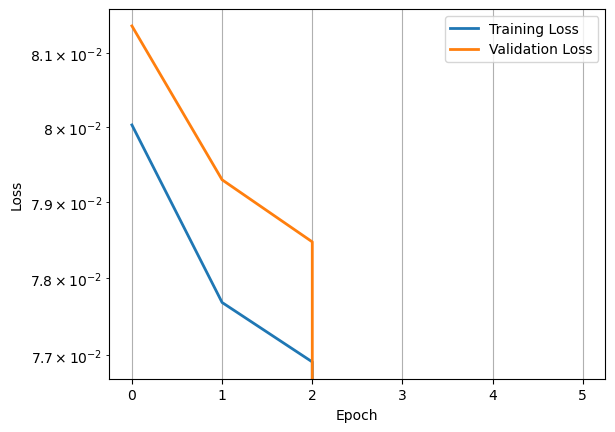

In [191]:
plt.plot(range(n_epochs), loss_per_epoch, lw=2, label="Training Loss")
plt.plot(range(n_epochs), val_loss_per_epoch, lw=2, label="Validation Loss")
# plt.xlim(0, 10)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.yscale("log")

In [143]:
model = AutoEncoder([768, 768, 768], kernel_size=3, stride=2).to(device)
model.load_state_dict(torch.load("model_epoch_4.pth"))

<All keys matched successfully>

In [161]:
sigmoid = torch.nn.Sigmoid()

In [162]:
# Compute the F1 score for the validation data
val_batch_size = 100
val_n_voxels = [len(t) for t in val_truth]
val_n_voxels_cumsum = np.cumsum(val_n_voxels)

preds = []

for i, batch in enumerate(range(0, len(val_truth), val_batch_size)):
    voxel_i_lower = 0 if batch == 0 else val_n_voxels_cumsum[batch - 1]
    voxel_i_upper = val_n_voxels_cumsum[batch + val_batch_size-1] if (batch + val_batch_size-1) < len(val_truth) else val_n_voxels_cumsum[-1]
    batch_input_feats = val_input_feats_scaled[voxel_i_lower:voxel_i_upper]
    batch_input_coords = val_input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
    
    print(batch_input_coords[:, 0].min().item(), batch_input_coords[:, 0].max().item())
    # From batch_input_coords, subtract the batch number to make indices start from 0
    batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch
    # Defensive: skip if batch_input_coords is empty
    if batch_input_coords.shape[0] == 0:
        print("Empty batch. Skip")
        continue

    # Defensive: check max batch index only if not empty
    # if batch_input_coords.shape[0] > 0:
        # assert batch_input_coords[:, 0].max().item() == val_batch_size - 1, batch_input_coords[:, 0].max().item()
        # assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()
    
    model.eval()
    with torch.no_grad():
        output_sparse = model(batch_input_feats.to(device), batch_input_coords.to(device), batch_size=val_batch_size)
    
        preds.append(output_sparse.features)

preds = torch.cat(preds, dim=0).squeeze()
preds[torch.isnan(preds)] = 0  # Replace nan values with 0
# preds = sigmoid(preds)

0 99
100 199
200 299
300 399
400 499


In [165]:
preds_1 = compute_validation_output(model, val_truth, val_input_feats_scaled.to(device), val_input_coords.to(device), val_batch_size=1)
preds_100 = compute_validation_output(model, val_truth, val_input_feats_scaled.to(device), val_input_coords.to(device), val_batch_size=100)

In [185]:
torch.any(torch.isnan(preds_100))

tensor(False, device='cuda:0')

In [167]:
preds_1.squeeze()

tensor([-6.6039, -5.5086, -7.0902,  ..., -3.8732, -3.9856, -4.0037],
       device='cuda:0')

In [168]:
preds

tensor([-6.6039, -5.5086, -7.0902,  ...,  6.0580,  6.0658,  6.1260],
       device='cuda:0')

In [170]:
torch.testing.assert_close(preds_1.squeeze(), preds_100.squeeze(), rtol=1e-3, atol=1e-3)

AssertionError: Tensor-likes are not close!

Mismatched elements: 485572 / 2187515 (22.2%)
Greatest absolute difference: 14.402997016906738 at index (775329,) (up to 0.001 allowed)
Greatest relative difference: 133.23922729492188 at index (2177869,) (up to 0.001 allowed)

(300000.0, 500000.0)

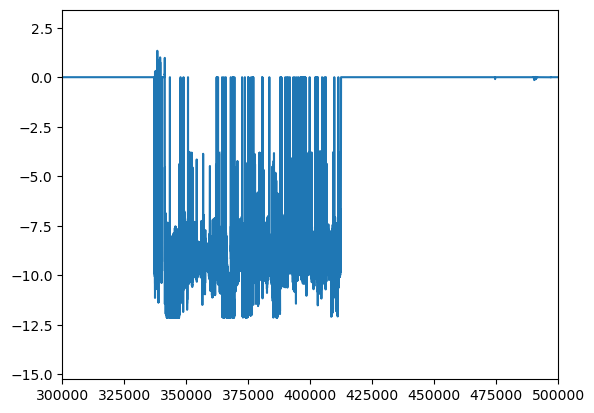

In [187]:
plt.plot((preds_1.squeeze() - preds_100.squeeze()).cpu().numpy())
plt.xlim(3e5, 5e5)

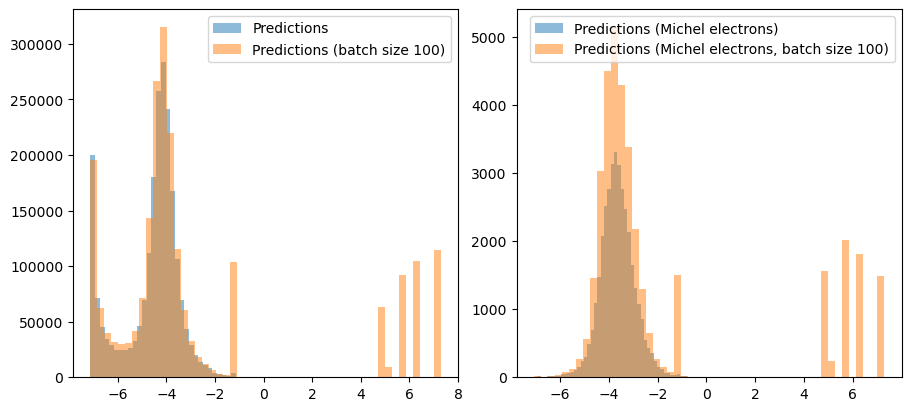

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

axs[0].hist(preds_1.cpu().numpy(), bins=50, alpha=0.5, label='Predictions')
axs[0].hist(preds_100.cpu().numpy(), bins=50, alpha=0.5, label='Predictions (batch size 100)')
axs[0].legend()

axs[1].hist(preds_1[val_truth_flat == 1].cpu().numpy(), bins=50, alpha=0.5, label='Predictions (Michel electrons)')
axs[1].hist(preds_100[val_truth_flat == 1].cpu().numpy(), bins=50, alpha=0.5, label='Predictions (Michel electrons, batch size 100)')
axs[1].legend()

In [106]:
torch.testing.assert_close(preds_1, preds_10, rtol=1e-3, atol=1e-3)

In [109]:
loss_fn(preds, torch.tensor(val_truth_flat, dtype=torch.float).to(device)).detach().item()

0.09617070108652115

In [60]:
preds2 = compute_validation_output(model, val_truth, val_input_feats.to(device), val_input_coords.to(device))

In [110]:
loss_fn(preds2.squeeze(), torch.tensor(val_truth_flat, dtype=torch.float).to(device)).detach().item()

0.09617070108652115

In [111]:
preds.shape, np.concatenate(val_truth).shape, preds2.shape

(torch.Size([2187515]), (2187515,), torch.Size([2187515, 1]))

In [112]:
np.mean(np.isclose(preds.cpu().numpy(), preds2.squeeze().cpu().numpy()))

np.float64(1.0)

In [65]:
preds[~np.isclose(preds.cpu().numpy(), preds2.squeeze().cpu().numpy())].detach().cpu().numpy()

array([   0.      ,    0.      ,    0.      , ..., -110.678345,
       -110.854706, -109.53375 ], shape=(485067,), dtype=float32)

In [82]:
preds2[~np.isclose(preds.cpu().numpy(), preds2.squeeze().cpu().numpy())].detach().cpu().numpy()

array([], shape=(0, 1), dtype=float32)

In [ ]:
f1s = []
f1_thresholds = np.arange(0, 1, 0.1)

for threshold in f1_thresholds:
    f1s.append(
        f1_score(
            val_truth_flat,
            sigmoid(preds_100).cpu().numpy() > threshold,
        )
    )

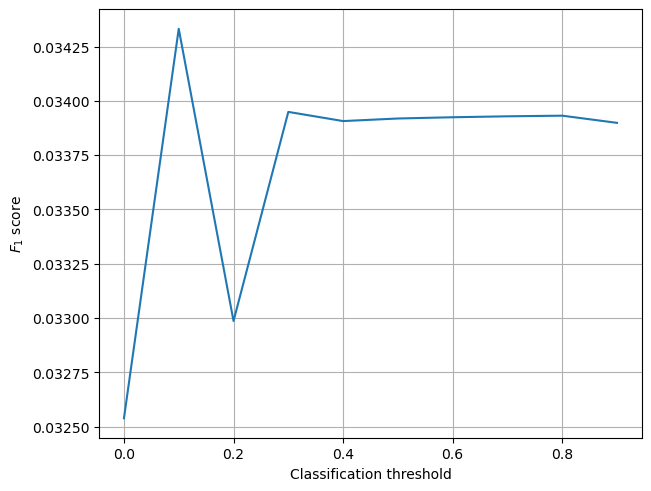

In [177]:
fig, ax = plt.subplots(layout="constrained")

ax.plot(f1_thresholds, f1s)
ax.set(xlabel="Classification threshold", ylabel="$F_1$ score")
ax.grid()

[Text(0.5, 0, 'Neural network output'), Text(0, 0.5, 'Number of voxels')]

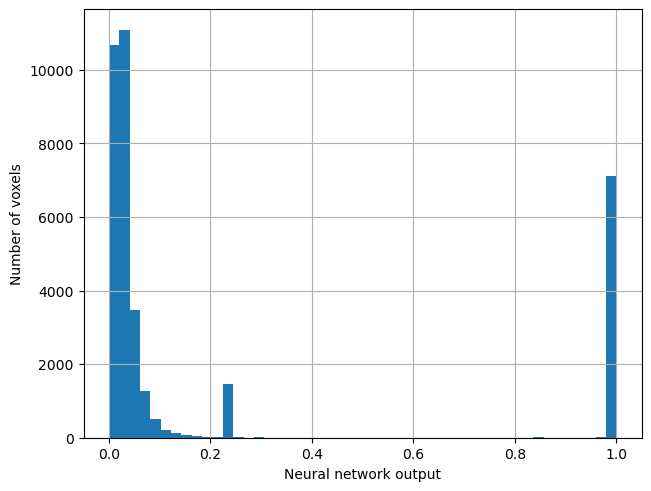

In [179]:
fig, ax = plt.subplots(layout="constrained")

ax.hist(sigmoid(preds_100[np.concatenate(val_truth) == 1]).cpu().numpy(), bins=np.linspace(0, 1, 50))
ax.grid()
ax.set(xlabel="Neural network output", ylabel="Number of voxels")

[Text(0.5, 0, 'Neural network output'), Text(0, 0.5, 'Number of voxels')]

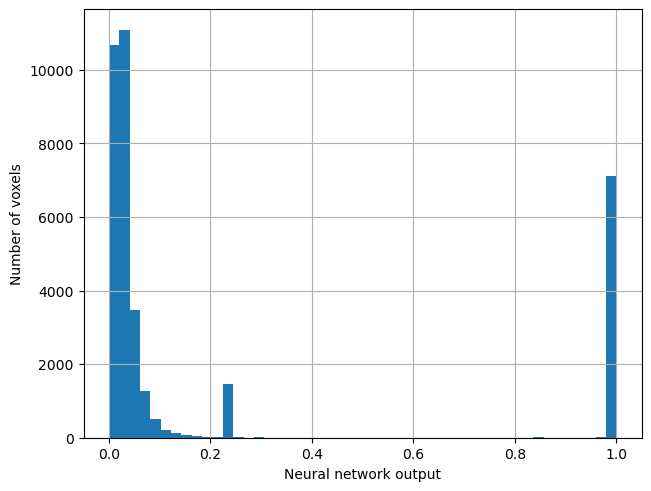

In [ ]:
fig, ax = plt.subplots(layout="constrained")

ax.hist(sigmoid(preds_100[np.concatenate(val_truth) == 0]).cpu().numpy(), bins=np.linspace(0, 1, 50))
ax.grid()
ax.set(xlabel="Neural network output", ylabel="Number of voxels")

In [31]:
val_n_voxels = [len(t) for t in val_truth]
val_n_voxels_cumsum = np.cumsum(val_n_voxels)

voxel_i_lower = 0
voxel_i_upper = val_n_voxels_cumsum[1]
batch_input_feats = val_input_feats[voxel_i_lower:voxel_i_upper]
batch_input_coords = val_input_coords[voxel_i_lower:voxel_i_upper].detach().clone()

print(batch_input_coords[:, 0].min().item(), batch_input_coords[:, 0].max().item())
# From batch_input_coords, subtract the batch number to make indices start from 0
# batch_input_coords[:, 0] = batch_input_coords[:, 0]

# Defensive: check max batch index only if not empty
# if batch_input_coords.shape[0] > 0:
    # assert batch_input_coords[:, 0].max().item() == val_batch_size - 1, batch_input_coords[:, 0].max().item()
    # assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()

model.eval()
with torch.no_grad():
    output_sparse = model(batch_input_feats.to(device), batch_input_coords.to(device), batch_size=1)

output_sparse.features

0 1


tensor([[-2.7698],
        [-3.1002],
        [-2.6654],
        ...,
        [-1.1424],
        [-1.1424],
        [-1.1424]], device='cuda:0')

In [32]:
v = spconv.SparseConvTensor(batch_input_feats, batch_input_coords, [768, 768, 768], 2)

In [54]:
v_sparse[0]

tensor(indices=tensor([[  0,   0,   0,  ...,   0,   0,   0],
                       [161, 161, 161,  ..., 561, 561, 561],
                       [420, 457, 468,  ..., 123, 123, 123],
                       [247, 243, 251,  ...,  74,  75,  76]]),
       values=tensor([ 0.0908,  0.1202,  0.2721,  ...,  6.0514,  8.3502,
                      14.1423]),
       size=(1, 768, 768, 768), nnz=8119, layout=torch.sparse_coo)

In [57]:
v_sparse[1]

tensor(indices=tensor([[  0,   0,   0,  ...,   0,   0,   0],
                       [  7,   7,   7,  ..., 493, 495, 500],
                       [375, 425, 427,  ..., 539, 333, 318],
                       [560, 456, 454,  ...,  49, 180, 237]]),
       values=tensor([0.1933, 0.4310, 0.0732,  ..., 0.0110, 0.0547, 0.0508]),
       size=(1, 768, 768, 768), nnz=10853, layout=torch.sparse_coo)

In [39]:
import torch.sparse as ts

In [ ]:
v_dense = v.dense().to_sparse()

In [42]:
v_dense.shape

torch.Size([2, 1, 768, 768, 768])

In [43]:
v_sparse = v_dense.to_sparse()

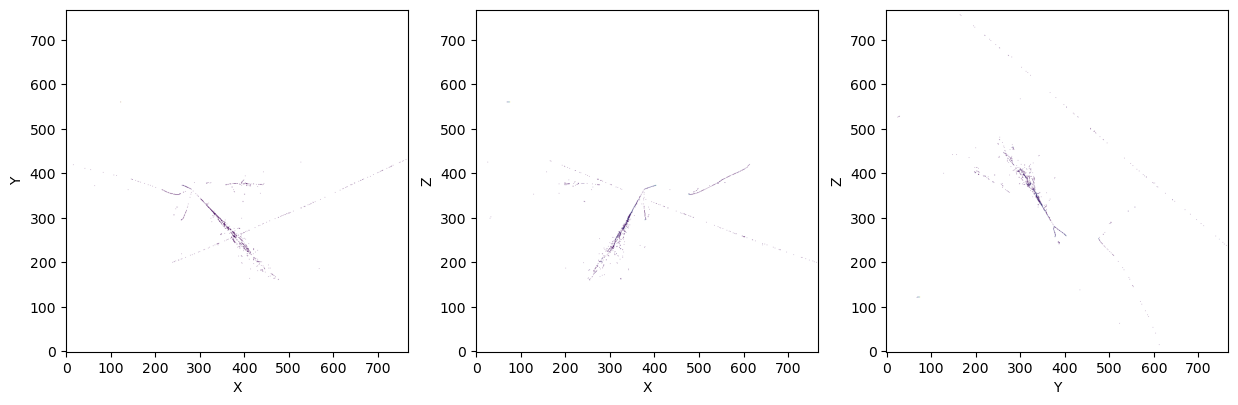

In [49]:
# Visualize v_dense
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
ax[0].imshow(v_sparse[0, 0, ...].sum(axis=2).to_dense().cpu(), origin='lower', vmin=1, cmap=cmap)
ax[0].set(xlabel='X', ylabel='Y')
ax[1].imshow(v_sparse[0, 0, ...].sum(axis=1).to_dense().cpu(), origin='lower', vmin=1, cmap=cmap)
ax[1].set(xlabel='X', ylabel='Z')
ax[2].imshow(v_sparse[0, 0, ...].sum(axis=0).to_dense().cpu(), origin='lower', vmin=1, cmap=cmap)
ax[2].set(xlabel='Y', ylabel='Z')
plt.show()

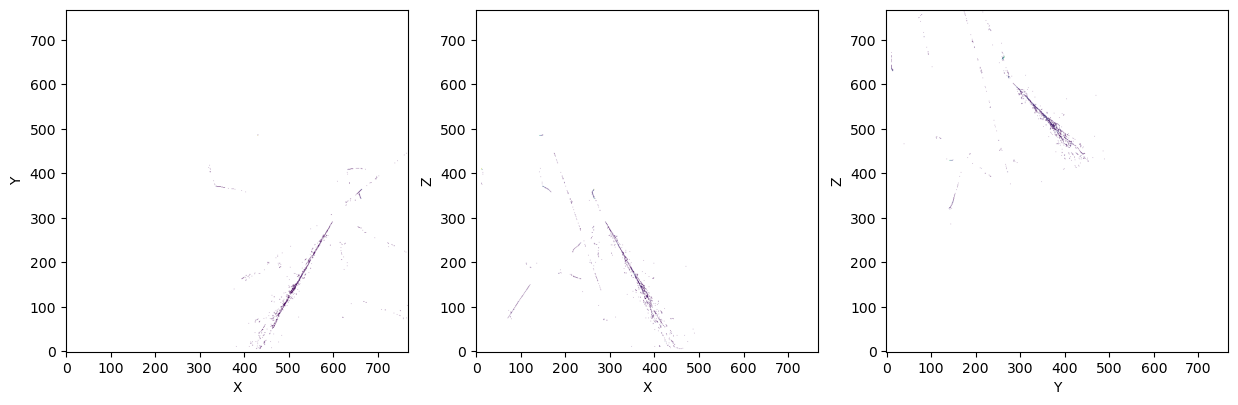

In [38]:
# Visualize v_dense
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
ax[0].imshow(v_dense[1, 0, ...].sum(axis=2).cpu(), origin='lower', vmin=1, cmap=cmap)
ax[0].set(xlabel='X', ylabel='Y')
ax[1].imshow(v_dense[1, 0, ...].sum(axis=1).cpu(), origin='lower', vmin=1, cmap=cmap)
ax[1].set(xlabel='X', ylabel='Z')
ax[2].imshow(v_dense[1, 0, ...].sum(axis=0).cpu(), origin='lower', vmin=1, cmap=cmap)
ax[2].set(xlabel='Y', ylabel='Z')
plt.show()